In [1]:
import os
import cv2

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.losses import binary_crossentropy

KeyboardInterrupt: 

In [33]:
def load_data(images_path, masks_path):
    images = []
    masks = []
    
    for img_name in os.listdir(images_path):
        img = cv2.imread(os.path.join(images_path, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))  # Изменяем размер
        img = img / 255.0  # Нормализация
        images.append(img)

        mask_name = img_name
        mask = cv2.imread(os.path.join(masks_path, mask_name), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256))
        mask = (mask > 0).astype(np.float32)  # Бинаризация
        masks.append(mask)

    return np.array(images), np.array(masks)

In [34]:
def plot_results(original_images, true_masks, predicted_masks, num=5):
    plt.figure(figsize=(20, 13))

    for i in range(num):
        idx = np.random.randint(len(original_images))
        plt.subplot(4, num, i + 1)
        plt.imshow(original_images[idx], cmap="gray")
        plt.axis("off")
        plt.title("Image")

        plt.subplot(4, num, i + num + 1)
        plt.imshow(true_masks[idx], cmap="gray")
        plt.axis("off")
        plt.title("Original Mask")

        plt.subplot(4, num, i + 2 * num + 1)
        plt.imshow((predicted_masks[idx] > 0.5).astype(np.float32), cmap="gray")
        plt.axis("off")
        plt.title("Predicted Mask")
        
        plt.subplot(4, num, i + 3 * num + 1)
        plt.imshow(predicted_masks[idx] * original_images[idx], cmap="gray")
        plt.axis("off")
        plt.title("Predicted image")

    plt.show()

In [35]:
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))  # Изменяем размер
    img = img / 255.0  # Нормализация

    return np.array(img).reshape(1, 256, 256, 3)

In [36]:
def plot_result(original_image, predicted_mask1, predicted_mask2):
    plt.figure(figsize=(20, 80))

    plt.subplot(1, 5, 1)
    plt.imshow(original_image[0], cmap="gray")
    plt.axis("off")
    plt.title("Image")

    plt.subplot(1, 5, 2)
    plt.imshow((predicted_mask1 > 0.5).astype(np.float32), cmap="gray")
    plt.axis("off")
    plt.title("Predicted Mask ffnn")
    
    plt.subplot(1, 5, 3)
    plt.imshow((predicted_mask1 * original_image)[0], cmap="gray")
    plt.axis("off") 
    plt.title("Predicted image ffnn")

    plt.subplot(1, 5, 4)
    plt.imshow((predicted_mask2 > 0.5).astype(np.float32), cmap="gray")
    plt.axis("off")
    plt.title("Predicted Mask cond")
    
    plt.subplot(1, 5, 5)
    plt.imshow((predicted_mask2 * original_image)[0], cmap="gray")
    plt.axis("off")
    plt.title("Predicted image cond")

    plt.show()

In [37]:
X, Y = load_data("images_apple", "labels_apple")

In [38]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [39]:
def weighted_binary_crossentropy(weights):
    def loss(y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        bce = binary_crossentropy(y_true, y_pred)

        return tf.reduce_mean(bce * weights)
    return loss

In [40]:
model_fc = keras.Sequential([
    layers.Flatten(input_shape=(256, 256, 3)),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256 * 256, activation='sigmoid'),  # Выход в виде плоского массива
    layers.Reshape((256, 256, 1))  # Обратное преобразование в сегментацию
])
model_fc.compile(optimizer='adam', loss=weighted_binary_crossentropy(1), metrics=['accuracy', 'precision'])

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:
history = model_fc.fit(X_train, Y_train, batch_size=10, 
            validation_data=(X_val, Y_val),
            epochs=40)

Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.6327 - loss: 0.6370 - precision: 0.6980 - val_accuracy: 0.8153 - val_loss: 0.4237 - val_precision: 0.8666
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8253 - loss: 0.3919 - precision: 0.8768 - val_accuracy: 0.8504 - val_loss: 0.3358 - val_precision: 0.9123
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.8553 - loss: 0.3095 - precision: 0.8943 - val_accuracy: 0.8675 - val_loss: 0.2927 - val_precision: 0.9060
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8883 - loss: 0.2408 - precision: 0.8991 - val_accuracy: 0.8751 - val_loss: 0.2725 - val_precision: 0.9096
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9143 - loss: 0.1959 - precision: 0.9146 - val_accuracy: 0.8799 - val_loss: 0.2702 - val_precision: 0.8983
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9225 - loss: 0.1798 - precision: 0.9225 - val_accuracy: 0.8757 - val_loss: 0.2761 - val_precision: 

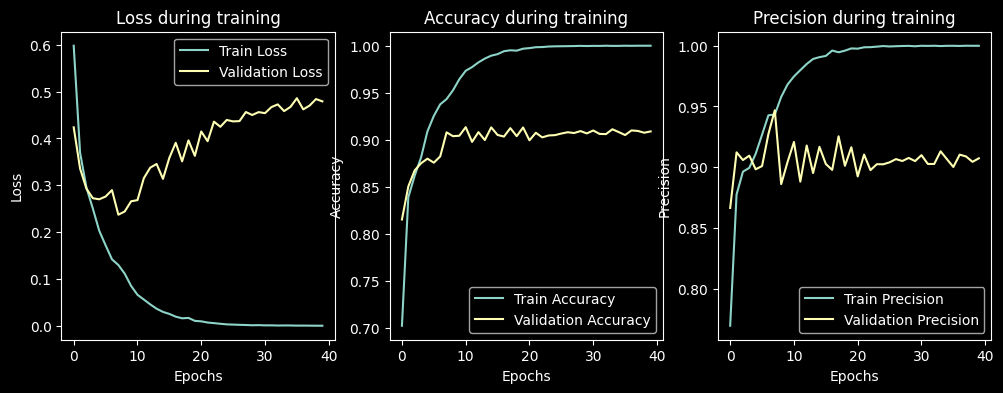

In [42]:
# График потерь
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# График точности
plt.subplot(1, 3, 3)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision during training')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.show()

In [45]:
Y_pred_ffnn = model_fc.predict(X_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


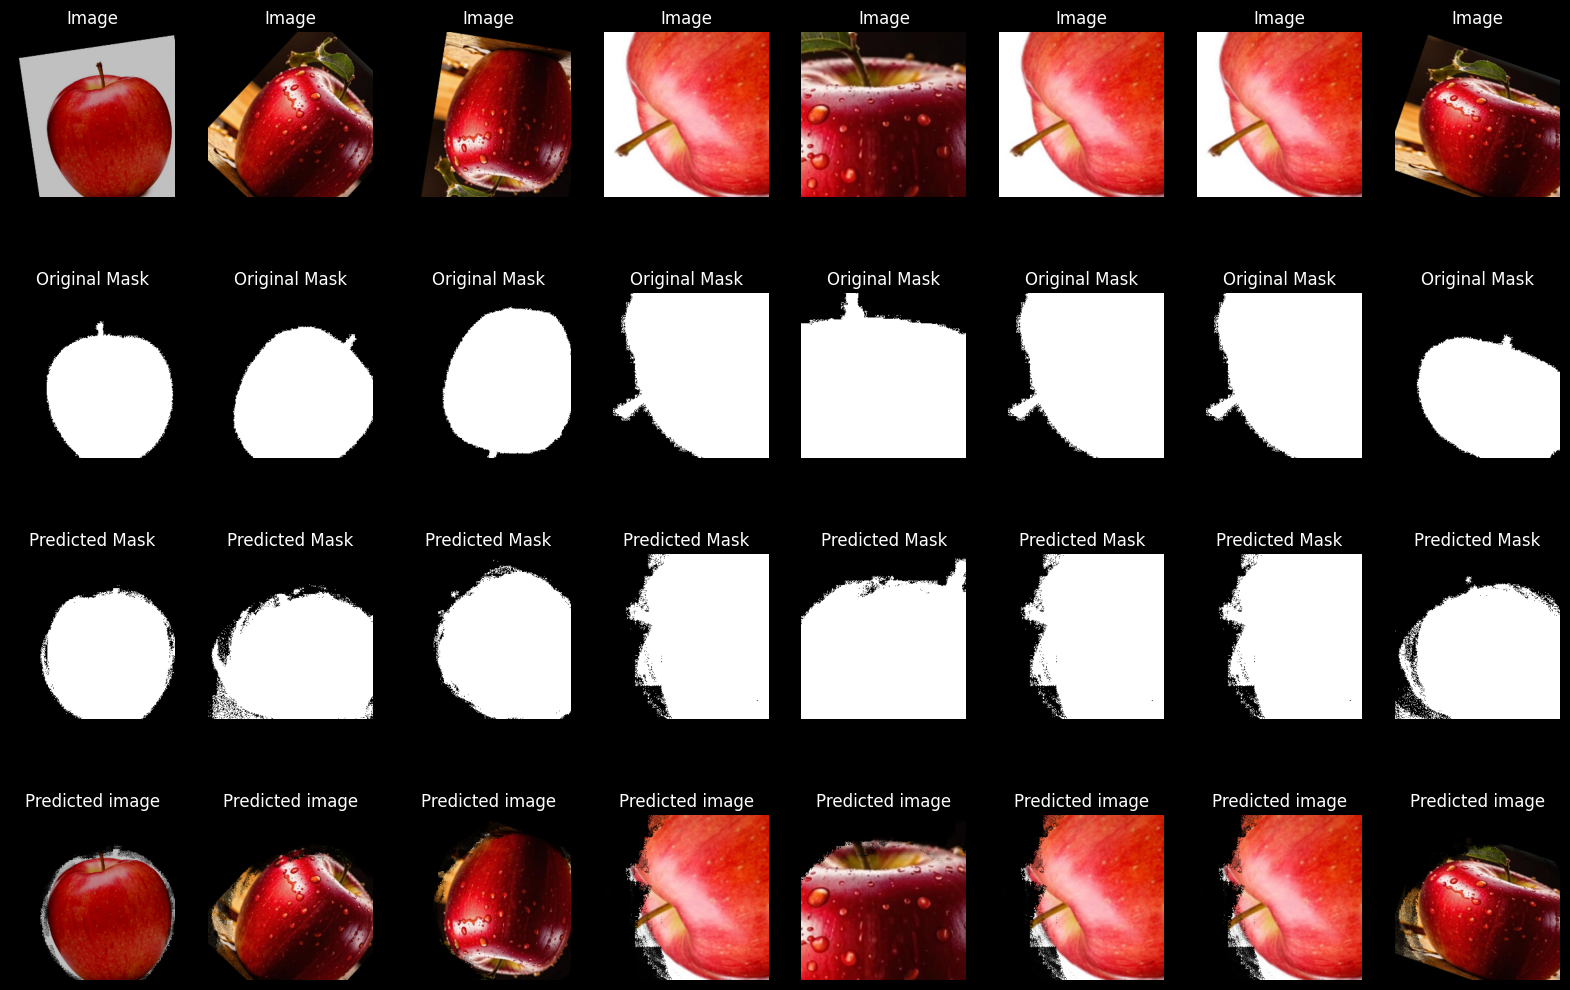

In [46]:
plot_results(X_val, Y_val, Y_pred_ffnn, num=8)

In [47]:
Y_pred = (Y_pred_ffnn > 0.5).astype(np.float32)
# Вычисление метрик
accuracy = np.mean(Y_pred.flatten() == Y_val.flatten())
precision = precision_score(Y_val.flatten(), Y_pred.flatten())
recall = recall_score(Y_val.flatten(), Y_pred.flatten())

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Accuracy: 0.9089, Precision: 0.9074, Recall: 0.9460


In [49]:
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Энергия спуска
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Декодирование
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

In [50]:
model_unet = unet_model((256, 256, 3))
model_unet.compile(optimizer='adam', loss=weighted_binary_crossentropy(1), metrics=['accuracy', 'precision'])

In [51]:
history = model_unet.fit(X_train, Y_train, batch_size=10, validation_data=(X_val, Y_val), epochs=25)

Epoch 1/25


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_44']. Received: the structure of inputs=*
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 128s 22s/step - accuracy: 0.6095 - loss: 0.6622 - precision: 0.6120 - val_accuracy: 0.8497 - val_loss: 0.4729 - val_precision: 0.8554
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 109s 21s/step - accuracy: 0.8779 - loss: 0.4086 - precision: 0.8714 - val_accuracy: 0.8900 - val_loss: 0.3554 - val_precision: 0.9622
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 137s 29s/step - accuracy: 0.9110 - loss: 0.2855 - precision: 0.9750 - val_accuracy: 0.9280 - val_loss: 0.2308 - val_precision: 0.9308
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 122s 24s/step - accuracy: 0.9494 - loss: 0.1583 - precision: 0.9670 - val_accuracy: 0.9457 - val_loss: 0.1322 - val_precision: 0.9621
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 130s 27s/step - accuracy: 0.9574 - loss: 0.1239 - precision: 0.9711 - val_accuracy: 0.9463 - val_loss: 0.1320 - val_precision: 0.9585
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 139s 29s/step - accuracy: 0.9471 - loss: 0.1474 - precision: 0.9607 - val_accuracy: 0.9486 - val_loss: 0.1263 - val_precision

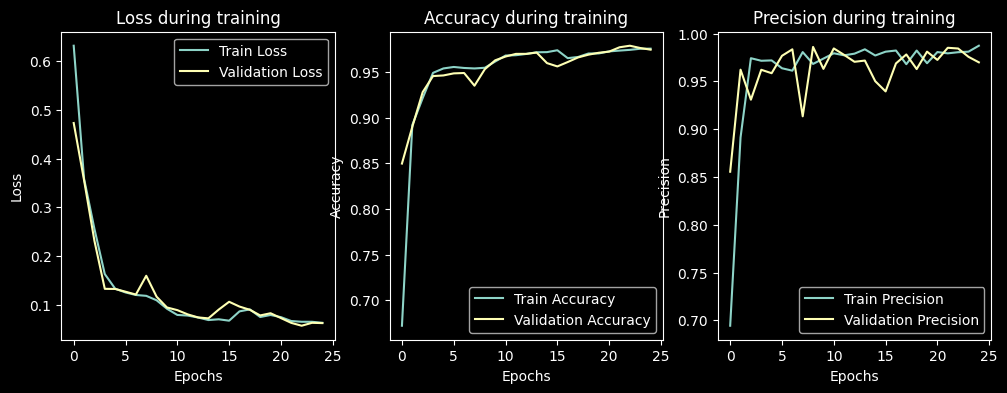

In [52]:
# График потерь
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# График точности
plt.subplot(1, 3, 3)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision during training')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.show()

In [53]:
# Предсказание на валидационных данных
Y_pred_unet = model_unet.predict(X_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


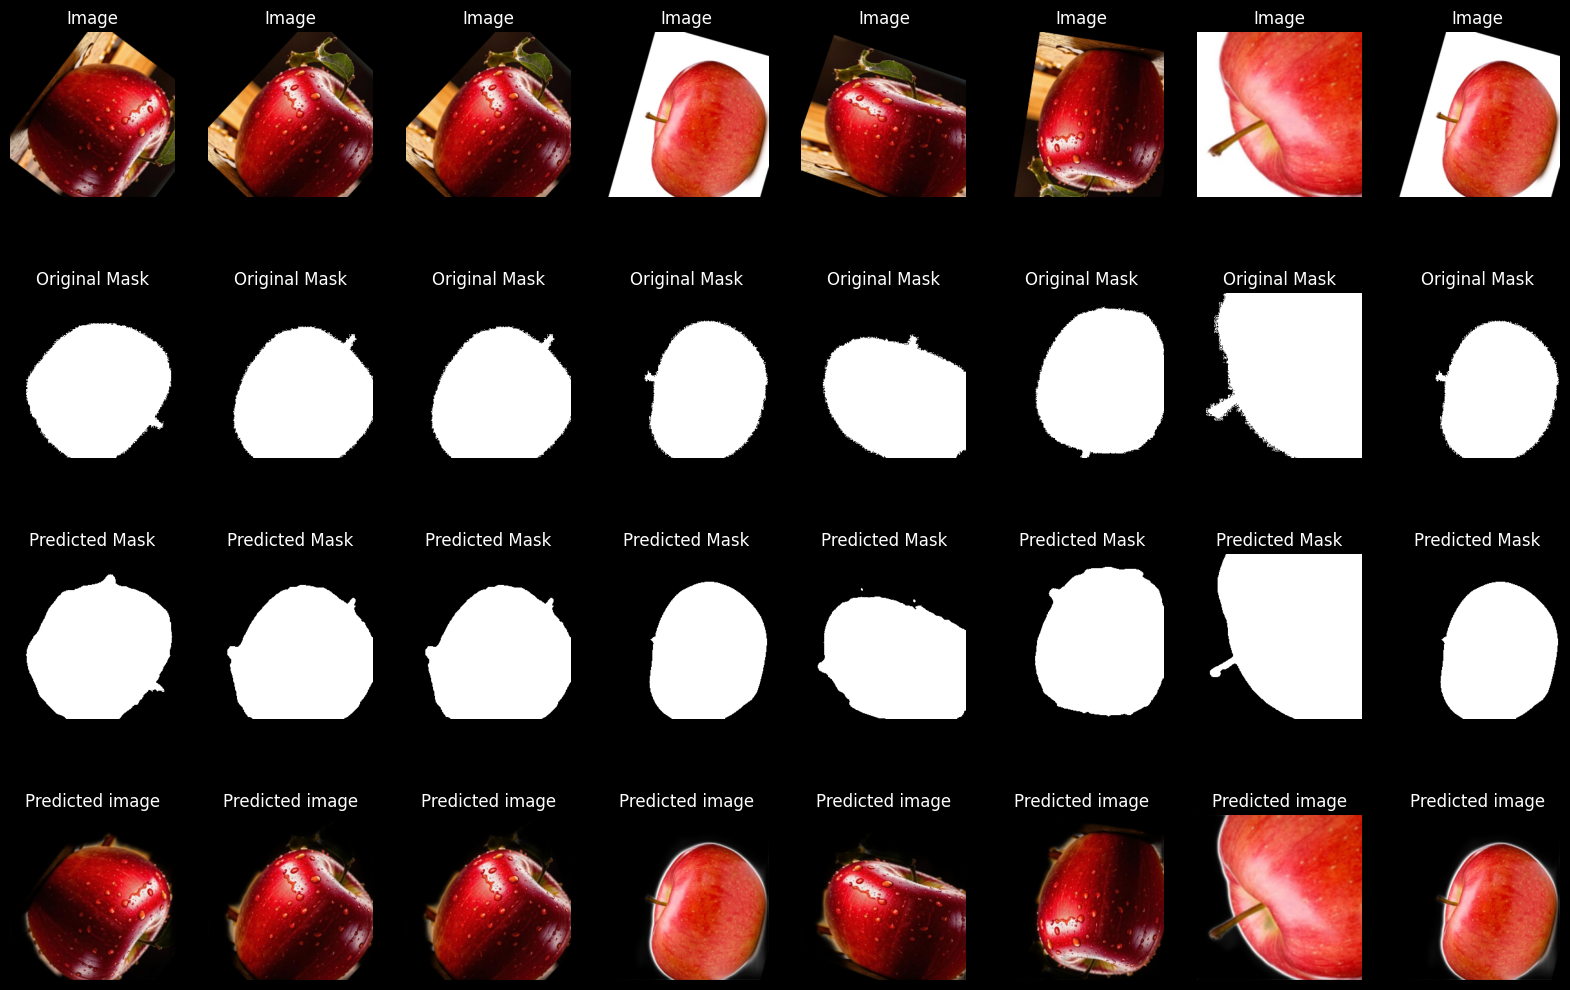

In [54]:
plot_results(X_val, Y_val, Y_pred_unet, num=8)

In [55]:
Y_pred = (Y_pred_unet > 0.5).astype(np.float32)
# Вычисление метрик
accuracy = np.mean(Y_pred.flatten() == Y_val.flatten())
precision = precision_score(Y_val.flatten(), Y_pred.flatten())
recall = recall_score(Y_val.flatten(), Y_pred.flatten())

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Accuracy: 0.9746, Precision: 0.9699, Recall: 0.9887


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_44']. Received: the structure of inputs=*
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


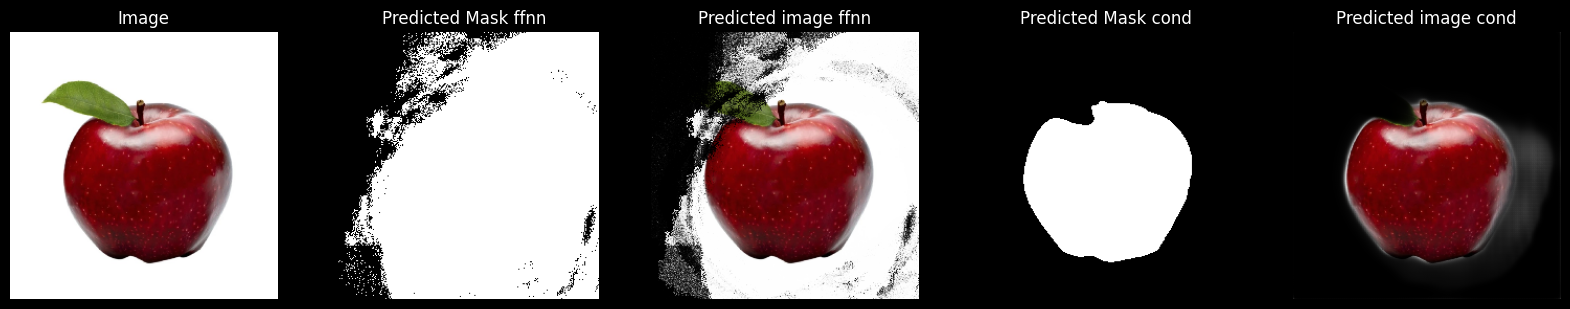

In [56]:
img = load_image('apple_test/1.jpg')
mask1 = model_fc.predict(img)[0]
mask2 = model_unet.predict(img)[0]
plot_result(img, mask1, mask2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


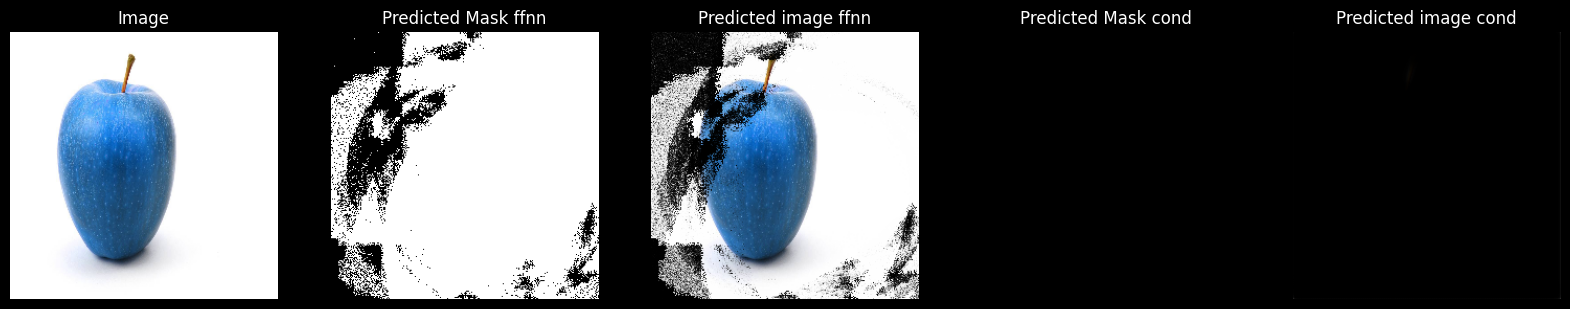

In [57]:
img = load_image('apple_test/2.jpg')
mask1 = model_fc.predict(img)[0]
mask2 = model_unet.predict(img)[0]
plot_result(img, mask1, mask2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


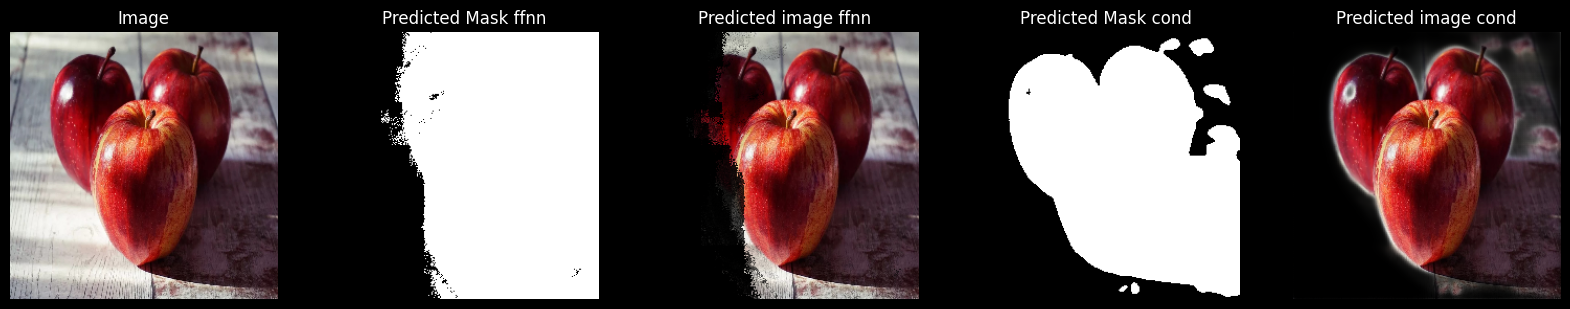

In [58]:
img = load_image('apple_test/3.jpg')
mask1 = model_fc.predict(img)[0]
mask2 = model_unet.predict(img)[0]
plot_result(img, mask1, mask2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


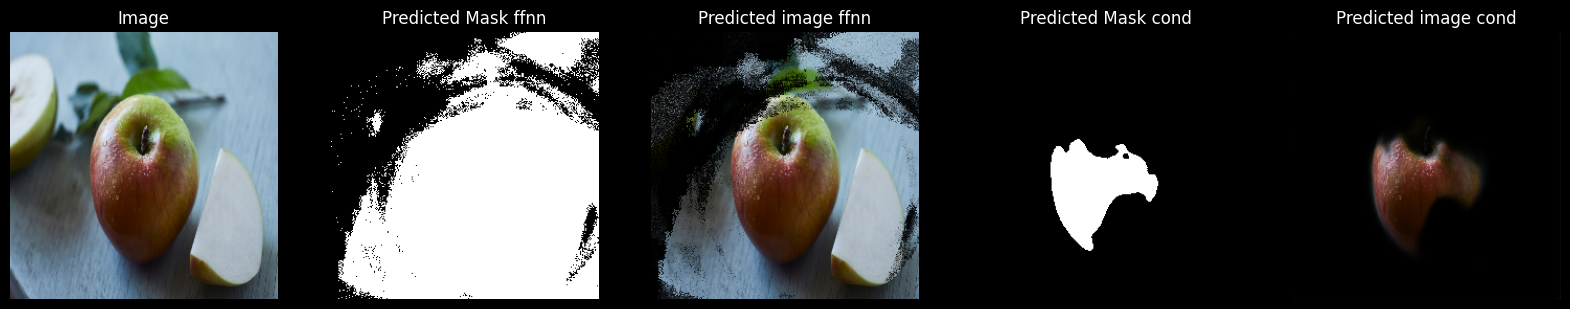

In [59]:
img = load_image('apple_test/4.jpg')
mask1 = model_fc.predict(img)[0]
mask2 = model_unet.predict(img)[0]
plot_result(img, mask1, mask2)